In [51]:
import os
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.pyplot.rcParams['figure.figsize'] = (15, 3)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'
#import seaborn
import pickle
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cross_validation import train_test_split

# Preparing the dataset

In [3]:
with open('stations_min_filtered.pickle', 'rb') as handle:
    stations_min_filtered = pickle.load(handle)

In [4]:
stations_min_filtered.columns

Index(['day', 'station_id', 'bikes_available', 'docks_available', 'time',
       'is_holiday', 'landmark', 'dockcount', 'Date', 'Max_Temperature_F',
       'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F',
       'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity ',
       'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Cloud_Cover ', 'Events',
       'Wind_Dir_Degrees', 'zip', 'trips_all_year'],
      dtype='object')

In [5]:
# generating np.array of predictors
X = stations_min_filtered[['is_holiday', 'dockcount', 'trips_all_year', 'Max_Temperature_F',
       'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F',
       'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity ',
       'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Cloud_Cover ']].fillna(.0).values

In [6]:
# standardization of the predictors
X_scaled = preprocessing.scale(X)

In [7]:
# transforming categorical data to dummy variables
encoder = OneHotEncoder()
label_encoder = LabelEncoder()

In [8]:
# encodin city names to numerical variables
landmark_label_encoded = label_encoder.fit_transform(stations_min_filtered['landmark'])

In [9]:
# transforming categorical data to vectors
stations_min_filtered['landmark'] = landmark_label_encoded
landmark_one_hot_encoded = encoder.fit_transform(stations_min_filtered[['landmark']].as_matrix())
station_id_one_hot_encoded = encoder.fit_transform(stations_min_filtered[['station_id']].as_matrix())

In [11]:
# converting the sparcse matrices to arrays so they can be joined with the X array
landmark_one_hot_encoded = landmark_one_hot_encoded.toarray()
station_id_one_hot_encoded = station_id_one_hot_encoded.toarray()

In [12]:
# adding these dummies to the predictors
X_matrix = np.hstack((X_scaled, landmark_one_hot_encoded, station_id_one_hot_encoded))

In [13]:
# selecting minimum bikes avaliable as the target variable
y = stations_min_filtered[['bikes_available']].values

# Baseline

In [44]:
# the accuracy of the models will be compared to a baseling: averaging the target values
class BaselineRegressor(BaseEstimator, RegressorMixin):
 
    def fit(self, X, y=None):
        self.baseline = y.mean()
    
    def predict(self, X, y=None):
        return np.ones((X.shape[0], )) * self.baseline

In [45]:
baseline = BaselineRegressor()

In [46]:
base_score = cross_validation.cross_val_score(baseline, X_matrix, y, cv=5)

In [47]:
print("Accuracy: %0.2f (+/- %0.2f)" % (base_score.mean(), base_score.std() * 2))

Accuracy: -0.01 (+/- 0.03)


# Comparing three types of regularized regressions 

###Ridge

In [33]:
# Ridge regression model
ridge = Ridge()

In [20]:
# trying 5 different train-test split variations to see how stabile the accuracy of the model is
scores = cross_validation.cross_val_score(ridge, X_matrix, y, cv=5)

In [21]:
scores

array([ 0.38897577,  0.40995361,  0.43159714,  0.39121891,  0.4057716 ])

In [22]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.41 (+/- 0.03)


## Lasso

the model proved to be a lot better than using the average

In [35]:
lasso = Lasso()

In [36]:
scores = cross_validation.cross_val_score(lasso, X_matrix, y, cv=5)

In [37]:
scores

array([ 0.02843985,  0.00383139,  0.03217167,  0.01004169,  0.03529133])

In [38]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.02 (+/- 0.03)


## ElasticNet

In [40]:
elastic = ElasticNet()

In [41]:
scores = cross_validation.cross_val_score(elastic, X_matrix, y, cv=5)

In [42]:
scores

array([ 0.14289944,  0.10542627,  0.1326918 ,  0.10540039,  0.12899194])

In [43]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.12 (+/- 0.03)


## The best is the ridge model, especially compared to the baseline

In [52]:
### checking with different type of split method
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.33)

In [54]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)

In [55]:
y_hat = ridge.predict(X_test)

In [56]:
y_df = pd.DataFrame(y_test)
y_df.columns = ['observed']
y_df['predicted'] = y_hat
y_df['diff'] = abs(y_df.observed - y_df.predicted)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111a82358>]], dtype=object)

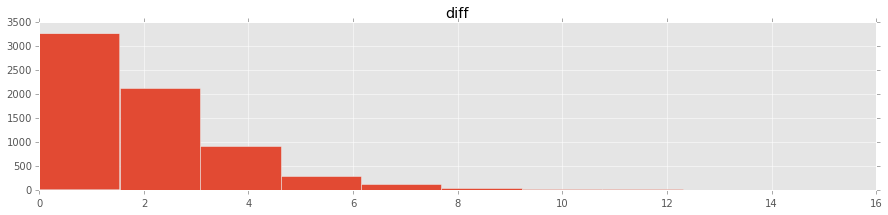

In [57]:
y_df.hist('diff')

In [58]:
y_df['diff'].describe()

count    6776.000000
mean        1.994274
std         1.658961
min         0.002311
25%         0.770796
50%         1.593402
75%         2.780584
max        15.373813
Name: diff, dtype: float64

### most of the cases the model misses by maximum 3 bikes, half of the cases it's only 1.6

# Predicting

In [61]:
pwd = os.getcwd()
os.chdir(pwd + '/201408_babs_open_data/')
station_df = pd.read_csv('201408_station_data.csv')

In [62]:
os.chdir(pwd)
with open('trips_by_stations.pickle', 'rb') as handle:
    trips_by_stations = pickle.load(handle)

## Let's find some weather data for next Tuesday
#### http://www.accuweather.com/en/us/san-francisco-ca/94103/daily-weather-forecast/347629?day=6
#### http://forecast.weather.gov/MapClick.php?w0=t&w1=td&w2=wc&w3=sfcwind&w3u=1&w4=sky&w5=pop&w6=rh&w7=rain&w8=thunder&w9=snow&w10=fzg&w11=sleet&AheadHour=48&FcstType=graphical&textField1=37.775&textField2=-122.418&site=all&unit=0&dd=&bw=&AheadDay.x=78&AheadDay.y=12&AheadDay=96

In [63]:
prediction = pd.DataFrame(columns = ['day', 'station_id', 'is_holiday', 'dockcount', 'trips_all_year', 'Max_Temperature_F',
       'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F',
       'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity ',
       'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Cloud_Cover ', 'landmark'])

prediction['station_id'] = station_df['station_id'].unique()
prediction['day'] = prediction['day'].fillna('2016-03-08')
prediction['is_holiday'] = prediction['is_holiday'].fillna(0)
prediction['dockcount'] = station_df['dockcount']
prediction['landmark'] = station_df['landmark']
prediction['trips_all_year'] = trips_by_stations['trips_all_year']

prediction['Max_Temperature_F'] = prediction['Max_Temperature_F'].fillna(59)
prediction['Min_TemperatureF'] = prediction['Min_TemperatureF'].fillna(51)
prediction['Mean_Temperature_F'] = prediction['Mean_Temperature_F'].fillna(55)

prediction['Min_Dewpoint_F'] = prediction['Min_Dewpoint_F'].fillna(45)
prediction['Max_Dew_Point_F'] = prediction['Max_Dew_Point_F'].fillna(56)
prediction['MeanDew_Point_F'] = prediction['MeanDew_Point_F'].fillna(50)

prediction['Min_Humidity '] = prediction['Min_Humidity '].fillna(53)
prediction['Max_Humidity'] = prediction['Max_Humidity'].fillna(90)
prediction['Mean_Humidity '] = prediction['Mean_Humidity '].fillna(71)

prediction['Max_Wind_Speed_MPH '] = prediction['Max_Wind_Speed_MPH '].fillna(22)
prediction['Mean_Wind_Speed_MPH '] = prediction['Mean_Wind_Speed_MPH '].fillna(11)
prediction['Max_Gust_Speed_MPH'] = prediction['Max_Gust_Speed_MPH'].fillna(22)

prediction['Cloud_Cover '] = prediction['Cloud_Cover '].fillna(6)
prediction['Precipitation_In '] = prediction['Precipitation_In '].fillna(0.3)

# as I didn't find foracast for sea level pressure and visibility, I'll use the averages from the original dataset
prediction['Min_Sea_Level_Pressure_In '] = prediction['Min_Sea_Level_Pressure_In '].fillna(29)
prediction['Max_Sea_Level_Pressure_In '] = prediction['Max_Sea_Level_Pressure_In '].fillna(31)
prediction['Mean_Sea_Level_Pressure_In '] = prediction['Mean_Sea_Level_Pressure_In '].fillna(30)

prediction['Min_Visibility_Miles '] = prediction['Min_Visibility_Miles '].fillna(10)
prediction['Max_Visibility_Miles '] = prediction['Max_Visibility_Miles '].fillna(10)
prediction['Mean_Visibility_Miles '] = prediction['Mean_Visibility_Miles '].fillna(10)

In [64]:
# generating np.array of predictors
X = prediction[['is_holiday', 'dockcount', 'trips_all_year', 'Max_Temperature_F',
       'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F',
       'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity ',
       'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Cloud_Cover ']].fillna(.0).values

In [65]:
# standardization of the predictors
X_scaled = preprocessing.scale(X)

/Users/somoseszter/anaconda/lib/python3.4/site-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [66]:
# encodin city names to numerical variables
landmark_label_encoded = label_encoder.fit_transform(prediction['landmark'])

In [67]:
# transforming categorical data to vectors
prediction['landmark'] = landmark_label_encoded
landmark_one_hot_encoded = encoder.fit_transform(prediction[['landmark']].as_matrix())
station_id_one_hot_encoded = encoder.fit_transform(prediction[['station_id']].as_matrix())

In [68]:
# converting the sparcse matrices to arrays so they can be joined with the X array
landmark_one_hot_encoded = landmark_one_hot_encoded.toarray()
station_id_one_hot_encoded = station_id_one_hot_encoded.toarray()

In [69]:
# adding these dummies to the predictors
X_matrix = np.hstack((X_scaled, landmark_one_hot_encoded, station_id_one_hot_encoded))

Let's use the winning model: Ridge

In [70]:
# predicting
y_pred = ridge.predict(X_matrix)

In [71]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ['predicted']
y_pred_df['station_id'] = prediction['station_id']

In [73]:
# according to the predictions these stations will be almost empty sometime on Tuesday
danger_stations = y_pred_df[y_pred_df.predicted<2]
danger_stations = pd.merge(danger_stations, station_df[['station_id', 'landmark', 'name']], on='station_id', how='left')

In [74]:
danger_stations

,predicted,station_id,landmark,name
0,1.677891,45,San Francisco,Commercial at Montgomery
1,1.708349,48,San Francisco,Embarcadero at Vallejo
2,1.748053,54,San Francisco,Embarcadero at Bryant
3,1.271469,60,San Francisco,Embarcadero at Sansome
4,1.901158,62,San Francisco,2nd at Folsom
5,1.728179,64,San Francisco,2nd at South Park
6,1.716504,73,San Francisco,Grant Avenue at Columbus Avenue


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107a42198>]], dtype=object)

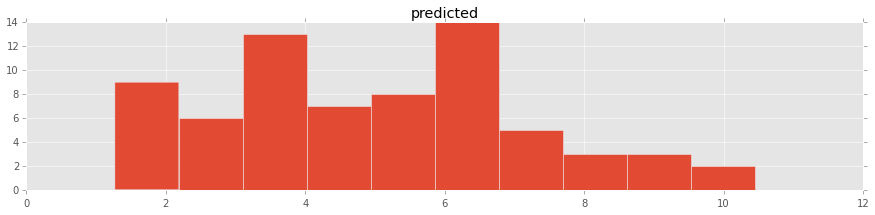

In [75]:
y_pred_df.hist('predicted')